In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from scipy.stats import wilcoxon
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

In [2]:
results_dir = Path("./results")
data_dir = Path("./data")
fig_dir = results_dir / "figures"

In [3]:
fig_dir.mkdir(parents=True, exist_ok=True)

In [4]:
rename_methods = {
    "leiden": "Leiden HVG PCA",
    "spatial_leiden": "SpatialLeiden HVG PCA",
    "leiden_svg": "Leiden SVG PCA",
    "spatial_leiden_svg": "SpatialLeiden SVG PCA",
    "leiden_svg_multispati": "Leiden SVG msPCA",
    "spatial_leiden_svg_multispati": "SpatialLeiden SVG msPCA",
}

In [5]:
groundtruth = pd.DataFrame(
    [(f.parent.name, f) for f in data_dir.glob("*/labels.tsv")],
    columns=["sample", "groundtruth"],
).set_index("sample")

results = {
    f.name: {tsv.stem: tsv for tsv in f.glob("*.tsv")} for f in results_dir.glob("Br*")
}

label_files = (
    pd.DataFrame(results)
    .transpose()
    .merge(groundtruth, left_index=True, right_index=True)
    .rename(columns=rename_methods)
)

# Fig1a Br8100-151673

In [6]:
sample = "Br8100_151673"

px_per_um = 96.40082438014726 / 65

In [7]:
coordinate_file = data_dir / sample / "coordinates.tsv"
image_file = data_dir / sample / "H_E.tiff"

In [8]:
from scipy.optimize import linear_sum_assignment

data = pd.read_table(coordinate_file, index_col=0)

files = label_files.loc[sample, :].copy()
labels_df = pd.read_table(files.pop("groundtruth"), index_col=0).astype("category")
labels_df.columns = ["groundtruth"]
labels_df["groundtruth"] = labels_df["groundtruth"].cat.rename_categories(
    {n: i for i, n in enumerate(labels_df.groundtruth.cat.categories)}
)

data = data.merge(labels_df, left_index=True, right_index=True)

for name, file in files.items():
    labels_df = pd.read_table(file, index_col=0).astype("category")
    labels_df.columns = [name]

    # match clusters
    contingency_table = pd.crosstab(labels_df[name], data["groundtruth"])
    row_ind, col_ind = linear_sum_assignment(contingency_table, maximize=True)
    labels_df[name] = labels_df[name].cat.rename_categories(
        dict(zip(contingency_table.index[row_ind], contingency_table.columns[col_ind]))
    )

    data = data.merge(labels_df, left_index=True, right_index=True)

In [9]:
from PIL import Image

# disable DecompressionBombWarning
Image.MAX_IMAGE_PIXELS = None

image = np.array(Image.open(image_file))

x_crop = (data["x"].min(), data["x"].max())
y_crop = (data["y"].min(), data["y"].max())

image = image[slice(*y_crop), slice(*x_crop)]
data = data.assign(x=lambda df: df["x"] - x_crop[0], y=lambda df: df["y"] - y_crop[0])

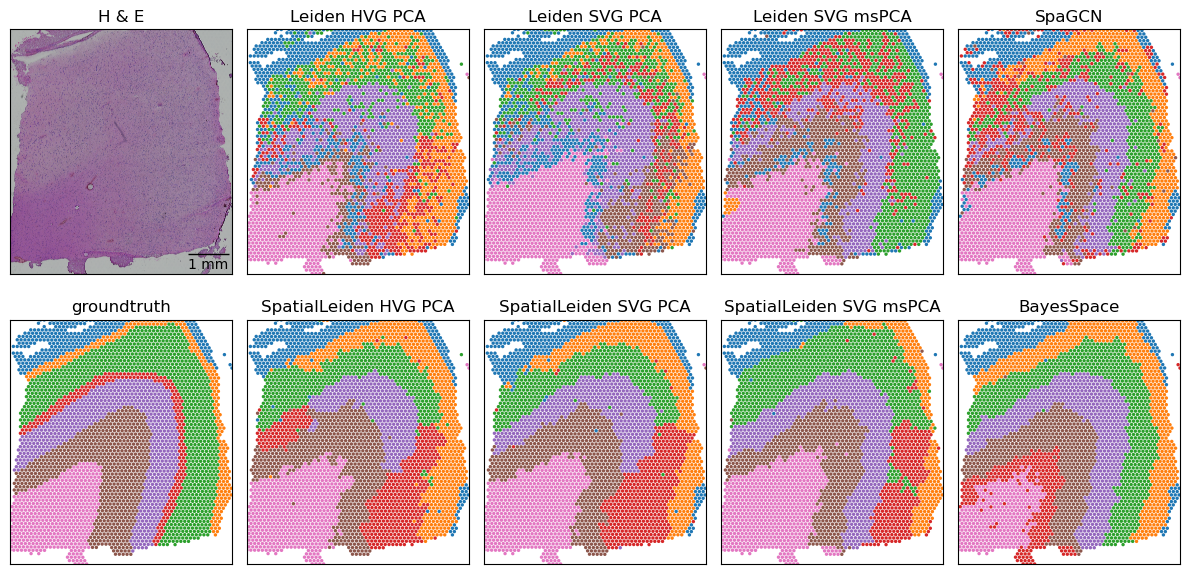

In [10]:
scatter_kwargs = {
    "s": 6,
    "linewidth": 0,
    "hue_order": data["groundtruth"].cat.categories,
}


def remove_tick_and_label(ax):
    ax.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel=None)
    ax.tick_params(left=False, bottom=False)


def scatter_labels(df, name, ax):
    _ = sns.scatterplot(df, x="x", y="y", hue=name, ax=ax, **scatter_kwargs)
    ax.set(title=name, aspect=1, xlim=(0, df["x"].max()), ylim=(df["y"].max(), 0))
    ax.legend([], [], frameon=False)
    remove_tick_and_label(ax)


fig, axs = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(12, 6))
_ = axs[0, 0].imshow(image)
axs[0, 0].set(title="H & E")
remove_tick_and_label(axs[0, 0])
scale_bar = AnchoredSizeBar(
    axs[0, 0].transData, px_per_um * 1_000, r"1 mm", loc="lower right", frameon=False
)
axs[0, 0].add_artist(scale_bar)

scatter_labels(data, "groundtruth", axs[1, 0])
scatter_labels(data, "Leiden HVG PCA", axs[0, 1])
scatter_labels(data, "SpatialLeiden HVG PCA", axs[1, 1])
scatter_labels(data, "Leiden SVG PCA", axs[0, 2])
scatter_labels(data, "SpatialLeiden SVG PCA", axs[1, 2])
scatter_labels(data, "Leiden SVG msPCA", axs[0, 3])
scatter_labels(data, "SpatialLeiden SVG msPCA", axs[1, 3])
scatter_labels(data, "SpaGCN", axs[0, 4])
scatter_labels(data, "BayesSpace", axs[1, 4])

fig.tight_layout(h_pad=2)
fig.savefig(fig_dir / "Fig1a.pdf", dpi=600)

# Fig1b ARI & NMI

In [11]:
def calculate_score(fn, groundtruth, cluster, **kwargs):
    domains = pd.read_table(cluster, index_col=0)["label"].astype("category").cat.codes
    groundtruth = (
        pd.read_table(groundtruth, index_col=0)["label"].astype("category").cat.codes
    )
    common_index = domains.index.intersection(groundtruth.index)
    return fn(groundtruth.loc[common_index], domains.loc[common_index], **kwargs)


def get_ncluster(file):
    return pd.read_table(file)["label"].astype("category").cat.categories.size

In [12]:
methods = label_files.columns.to_series().loc[lambda s: s != "groundtruth"].tolist()
scores = label_files.melt(
    id_vars="groundtruth",
    value_vars=methods,
    var_name="Method",
    value_name="filepath",
    ignore_index=False,
).assign(
    ARI=lambda df: df.apply(
        lambda row: calculate_score(adjusted_rand_score, row.groundtruth, row.filepath),
        axis=1,
    ),
    NMI=lambda df: df.apply(
        lambda row: calculate_score(
            normalized_mutual_info_score, row.groundtruth, row.filepath
        ),
        axis=1,
    ),
)

In [13]:
order = [
    "Leiden HVG PCA",
    "Leiden SVG PCA",
    "Leiden SVG msPCA",
    "SpatialLeiden HVG PCA",
    "SpatialLeiden SVG PCA",
    "SpatialLeiden SVG msPCA",
    "SpaGCN",
    "BayesSpace",
]

In [14]:
# check number of clusters
label_files.map(get_ncluster).sort_index()[["groundtruth"] + order]

,groundtruth,Leiden HVG PCA,Leiden SVG PCA,Leiden SVG msPCA,SpatialLeiden HVG PCA,SpatialLeiden SVG PCA,SpatialLeiden SVG msPCA,SpaGCN,BayesSpace
Br5292_151507,7,7,7,7,7,7,7,7,7
Br5292_151508,7,7,7,7,7,7,7,7,7
Br5292_151509,7,7,7,7,7,7,7,7,7
Br5292_151510,7,7,7,7,7,7,7,7,7
Br5595_151669,5,5,5,5,5,5,5,5,5
Br5595_151670,5,5,5,5,5,5,5,4,5
Br5595_151671,5,5,5,5,5,5,5,5,5
Br5595_151672,5,5,5,5,5,5,5,5,5
Br8100_151673,7,7,7,7,7,7,7,7,7
Br8100_151674,7,7,7,7,7,7,7,6,7


In [15]:
ari = scores.pivot(columns="Method", values="ARI")
nmi = scores.pivot(columns="Method", values="NMI")

ari.to_csv(fig_dir / "ARI.tsv", sep="\t")
nmi.to_csv(fig_dir / "NMI.tsv", sep="\t")

In [16]:
ari.median().sort_values(ascending=False)

Method
SpatialLeiden SVG msPCA    0.473413
BayesSpace                 0.468972
SpatialLeiden SVG PCA      0.467410
SpatialLeiden HVG PCA      0.420508
SpaGCN                     0.394364
Leiden SVG msPCA           0.391173
Leiden SVG PCA             0.345466
Leiden HVG PCA             0.335907
dtype: float64

In [17]:
nmi.median().sort_values(ascending=False)

Method
BayesSpace                 0.626629
SpatialLeiden SVG msPCA    0.607169
SpatialLeiden SVG PCA      0.600004
SpatialLeiden HVG PCA      0.557914
Leiden SVG msPCA           0.499375
SpaGCN                     0.493182
Leiden SVG PCA             0.443308
Leiden HVG PCA             0.425197
dtype: float64

In [18]:
# best performing method per sample
ari.idxmax(axis=1)

Br5292_151507    SpatialLeiden SVG msPCA
Br5292_151508                 BayesSpace
Br5292_151509                 BayesSpace
Br5292_151510    SpatialLeiden SVG msPCA
Br5595_151669                 BayesSpace
Br5595_151670                 BayesSpace
Br5595_151671    SpatialLeiden SVG msPCA
Br5595_151672      SpatialLeiden HVG PCA
Br8100_151673    SpatialLeiden SVG msPCA
Br8100_151674      SpatialLeiden SVG PCA
Br8100_151675                 BayesSpace
Br8100_151676    SpatialLeiden SVG msPCA
dtype: object

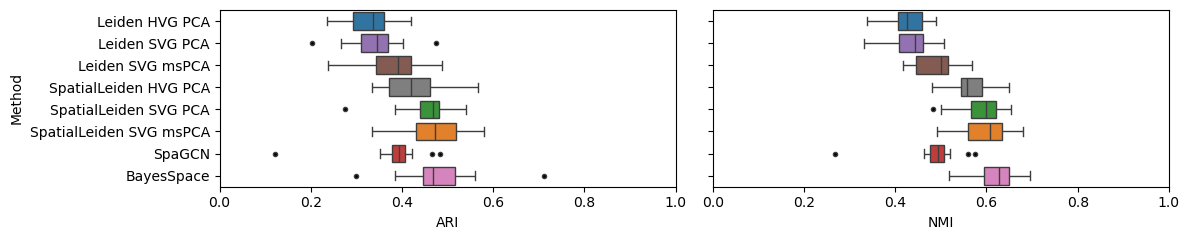

In [19]:
flierprops = dict(marker=".", markerfacecolor="black")

fig, axs = plt.subplots(ncols=2, figsize=(12, 2.5), sharex=True, sharey=True)
sns.boxplot(
    data=scores,
    y="Method",
    x="ARI",
    hue="Method",
    order=order,
    flierprops=flierprops,
    ax=axs[0],
)
_ = axs[0].set(xlim=(0, 1))

sns.boxplot(
    data=scores,
    y="Method",
    x="NMI",
    hue="Method",
    order=order,
    flierprops=flierprops,
    ax=axs[1],
)

fig.tight_layout()
fig.savefig(fig_dir / "Fig1b.pdf", dpi=600)

## test ARI

In [20]:
wilcoxon(ari["Leiden HVG PCA"], ari["SpatialLeiden HVG PCA"], alternative="less")

WilcoxonResult(statistic=0.0, pvalue=0.000244140625)

In [21]:
wilcoxon(ari["Leiden SVG PCA"], ari["SpatialLeiden SVG PCA"], alternative="less")

WilcoxonResult(statistic=4.0, pvalue=0.001708984375)

In [22]:
wilcoxon(ari["Leiden SVG msPCA"], ari["SpatialLeiden SVG msPCA"], alternative="less")

WilcoxonResult(statistic=3.0, pvalue=0.001220703125)

## test NMI

In [23]:
wilcoxon(nmi["Leiden HVG PCA"], nmi["SpatialLeiden HVG PCA"], alternative="less")

WilcoxonResult(statistic=0.0, pvalue=0.000244140625)

In [24]:
wilcoxon(nmi["Leiden SVG PCA"], nmi["SpatialLeiden SVG PCA"], alternative="less")

WilcoxonResult(statistic=0.0, pvalue=0.000244140625)

In [25]:
wilcoxon(nmi["Leiden SVG msPCA"], nmi["SpatialLeiden SVG msPCA"], alternative="less")

WilcoxonResult(statistic=0.0, pvalue=0.000244140625)

In [26]:
ari.to_csv(fig_dir / "ARI.tsv", sep="\t")
nmi.to_csv(fig_dir / "NMI.tsv", sep="\t")